# Demo Subcycle

This notebook shows a single run consisting of the following four phases:
* sail empty
* loading
* sail full
* unloading

In [1]:
import datetime, time
import simpy

import shapely.geometry


import pandas as pd
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}
keep_resources = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)


## Definition of Site

In [3]:
from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID="6dbbbdf4-4589-11e9-a501-b469212bff5d",
    geometry=location_from_site,
    capacity=100,
    level=50,
)


to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID="6dbbbdf5-4589-11e9-82b2-b469212bff5c",
    geometry=location_to_site,
    capacity=50,
    level=0,
)

## Definition of Vessels

In [4]:
hopper = TransportProcessingResource(
    env=my_env,
    name="Hopper 01",
    ID="6dbbbdf6-4589-11e9-95a2-b469212bff5b",
    geometry=location_from_site,
    loading_rate=0.00001,
    unloading_rate=0.00001,
    capacity=4,
    compute_v=lambda x: 10,
)

## Defenition of the activities

In [5]:
loading_subcycle_processes =[
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer MP",
        registry=registry,
        processor=hopper,
        origin=from_site,
        destination=hopper,
        amount=4,
        duration=1000,
    )
]

loading_subcycle_processes = model.SequentialActivity(
    env=my_env,
    name="Loading subcycle",
    registry=registry,
    sub_processes=loading_subcycle_processes,
)

In [7]:
single_run = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=hopper,
        destination=from_site,
    ),
    loading_subcycle_processes,
    model.MoveActivity(
        env=my_env,
        name="sailing filled",
        registry=registry,
        mover=hopper,
        destination=to_site,
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="Transfer TP",
        registry=registry,
        processor=hopper,
        origin=hopper,
        destination=to_site,
        amount=4,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="Basic activity",
        registry=registry,
        duration=0,
        additional_logs=[hopper],
    ),
]


activity = model.SequentialActivity(
    env=my_env,
    name="Single run process",
    registry=registry,
    sub_processes=single_run,
)


while_activity = model.WhileActivity(
    env=my_env,
    name="while",
    registry=registry,
    sub_processes=[activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

In [8]:
model.register_processes([while_activity])
my_env.run()

AssertionError: 

In [9]:
 plot.vessel_planning([hopper, from_site, to_site])

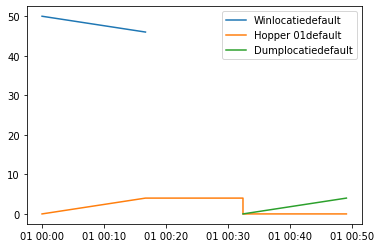

In [10]:
fig = plot.get_step_chart([from_site, hopper, to_site])

In [11]:
 plot.vessel_planning(single_run)